
Lesson: https://youtu.be/p4ZZq0736Po?feature=shared&t=3770

Dataset: https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset

Dataset citation:
>F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages. DOI=http://dx.doi.org/10.1145/2827872

In [1]:
!pip install kagglehub
!pip install fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.8/234.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 21.8 MB/s eta 0:00:00


In [64]:
import numpy as np
import pandas as pd
import torch
from torch import nn, tensor
import kagglehub

from torch.nn import Module
# Homebrew
#from kaggle_util import KaggleUtil

In [69]:
from fastai.collab import (
    untar_data, CollabDataLoaders, collab_learner,
    one_hot, Embedding,
    sigmoid_range, Learner,
    MSELossFlat, L
)

from fastai.tabular.all import (
    URLs, set_seed
)

In [4]:


# This 20m dataset is too large for our purpose. Let's use the dataset from fastai.
#path = kagglehub.dataset_download("grouplens/movielens-20m-dataset")
#print("Path to dataset files:", path)

#ratings = pd.read_csv(path, #header=None,
#                        #names=['user_id','movie_id','rating','timestamp'],
#                        low_memory=False
#                     )
#display(ratings.head())

In [5]:
# JH uses untar_data from fastai
path = untar_data(URLs.ML_100k)
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                        names=['userId','movieId','rating','timestamp']
                     )
display(ratings.head())

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


If we rearrange into a cross-tab format, it could look like this.

In [6]:
cross = pd.crosstab(ratings['userId'], ratings['movieId'],values=ratings['rating'], aggfunc=np.mean)
display(cross.head())
print(cross.shape)

/tmp/ipykernel_88/3412241578.py:1: FutureWarning: The provided callable <function mean at 0x7f5e10346480> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  cross = pd.crosstab(ratings['userId'], ratings['movieId'],values=ratings['rating'], aggfunc=np.mean)


movieId,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
userId,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(943, 1682)


There are a lot of NaN's. Let's see what we can do about those...

In [7]:
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1',
                     usecols=(0,1),names=('movie','title'), header=None
                    )
display(movies.head())

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [8]:
drop_cols = ['movie','timestamp']
mrg_ratings = ratings.merge(movies, left_on='movieId', right_on='movie').drop(drop_cols,axis=1)
display(mrg_ratings.head())

,userId,movieId,rating,title
0,196,242,3,Kolya (1996)
1,186,302,3,L.A. Confidential (1997)
2,22,377,1,Heavyweights (1994)
3,244,51,2,Legends of the Fall (1994)
4,166,346,1,Jackie Brown (1997)


In [9]:
#Create the data loader
dls = CollabDataLoaders.from_df(mrg_ratings, item_name='title', bs=64)
dls.show_batch()

,userId,title,rating
0,622,Heavy Metal (1981),5
1,932,Jumanji (1995),2
2,843,Independence Day (ID4) (1996),3
3,165,Aliens (1986),4
4,162,"Cable Guy, The (1996)",2
5,279,Marked for Death (1990),4
6,687,Liar Liar (1997),3
7,397,Down by Law (1986),5
8,699,Anaconda (1997),3
9,567,Strange Days (1995),3


In [10]:
n_users = len(dls.classes['userId'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
print(user_factors.t().shape)
print(user_factors.t())
movie_factors = torch.randn(n_movies, n_factors)

torch.Size([5, 944])
tensor([[-0.3626,  1.0081, -0.7268,  ...,  1.5124, -0.0293,  0.4972],
        [-0.3412, -0.1276, -0.4312,  ..., -0.3770, -0.5939, -0.5510],
        [-0.5297,  0.3403, -0.5506,  ...,  0.5123, -0.8102,  1.2359],
        [ 1.7736,  2.2770, -1.3760,  ...,  2.5058, -1.9956,  0.0267],
        [-0.0449,  0.7184, -0.3755,  ...,  0.7244, -0.1036,  0.1073]])


In [11]:
#Creates a 1D tensor/vector that has all 0's except for at user inex 3.
one_hot_3 = one_hot(3, n_users).float()
print(one_hot_3.shape)
print(one_hot_3[:5])

torch.Size([944])
tensor([0., 0., 0., 1., 0.])


In [12]:
print(user_factors.t().shape)
user_factors.t() @ one_hot_3

torch.Size([5, 944])


tensor([ 0.3462, -0.9093, -1.4875, -1.1152,  1.3071])

In [19]:
#Adding y_range to limit the output to ratings between 0 and 5.
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        super().__init__()
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
    
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return(sigmoid_range((users * movies).sum(dim=1), *self.y_range))
    

In [18]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model=model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.927894,1.018511,00:04
1,0.625849,0.947701,00:04
2,0.451934,0.957092,00:04
3,0.373652,0.951689,00:04
4,0.356088,0.950037,00:04


See [here](https://docs.google.com/spreadsheets/d/17SHzVlJwhjQA8XDq8F0mvu42NYM0f1D8wZLMFbmH1BE/edit?gid=1935024619#gid=1935024619) for a visualization of what MSE and RMSE could look like for different degrees of accuracy.

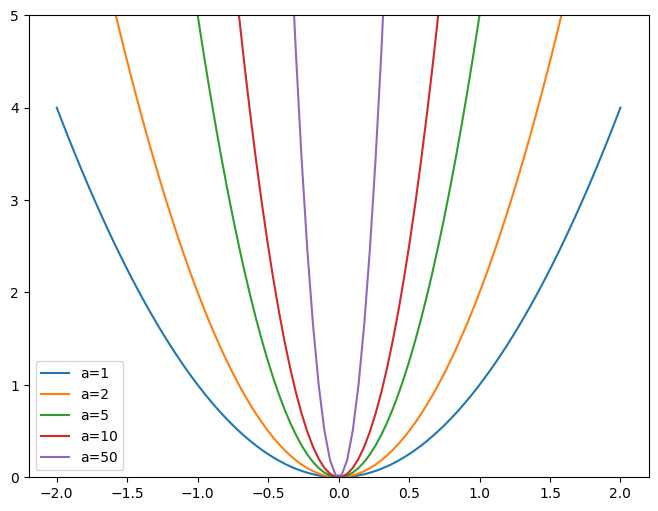

In [24]:
import matplotlib.pyplot as plt

x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50] 
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots(figsize=(8,6))
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend();

In [25]:
#Adding in weight decay. This function adds a sum of all weights squared.
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model=model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.964068,1.018758,00:04
1,0.728152,0.948244,00:04
2,0.611647,0.910447,00:04
3,0.511521,0.882691,00:04
4,0.504312,0.876513,00:04


In [33]:
class T(Module):
    def __init__(self): 
        super().__init__()
        self.a = nn.Parameter(torch.ones(3))

L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

In [36]:
class T(Module):
    def __init__(self): 
        super().__init__()
        self.a = nn.Linear(1, 3, bias=False)

t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[0.5661],
        [0.5804],
        [0.4986]], requires_grad=True)]

In [37]:
print(type(t.a.weight))

<class 'torch.nn.parameter.Parameter'>


In [38]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [47]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        super().__init__()
        #Users
        self.user_factors = create_params((n_users,n_factors))
        #Bias accounts for users that might be especially positive or negative.
        # Same for movies.
        self.user_bias = create_params([n_users])
        #Movies
        self.movie_factors = create_params((n_movies,n_factors))
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        #first column is users in this tensor. 2nd is movies.
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users * movies).sum(dim=1)
        #Adding the bias to our dotproduct to account for some users that are especially positive/negative and same with movies.
        #What does this do to our model? It encourages the loss function to adjust for those biases and 
        #raises/lowers them during backpropagation.
        #The term "b_u + b_m" is like an intercept for that individual user + movie combination.
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return(sigmoid_range(res, *self.y_range))

In [51]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(8, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.953727,0.991393,00:05
1,0.733141,0.913126,00:05
2,0.552877,0.889939,00:05
3,0.473930,0.886639,00:05
4,0.398949,0.883020,00:05
5,0.364129,0.875758,00:05
6,0.327727,0.869391,00:05
7,0.324929,0.868427,00:05


In [58]:
#Get the bias embeddings and remove the unnecessary dimension.
movie_bias = learn.model.movie_bias.squeeze()
print(movie_bias.shape)
#sort and assign 0-n ordinal from lowest to high values in movie_bias
idxs = movie_bias.argsort()[:5]
print(idxs)
#Grab the titles for the lowest to highest biases
display([dls.classes['title'][i] for i in idxs])

torch.Size([1665])
tensor([1216, 1282,   93, 1318, 1501], device='cuda:0')


['Rear Window (1954)',
 "Schindler's List (1993)",
 'Apt Pupil (1998)',
 'Shawshank Redemption, The (1994)',
 'Titanic (1997)']

An example to explain "torch.squeeze()"

>x = torch.randn(1, 10)
>
>print(x.shape)
>
>print(x)
>
>g = x.squeeze()  # => torch.Size([10])
>
>print(g.shape)
>
>print(g)


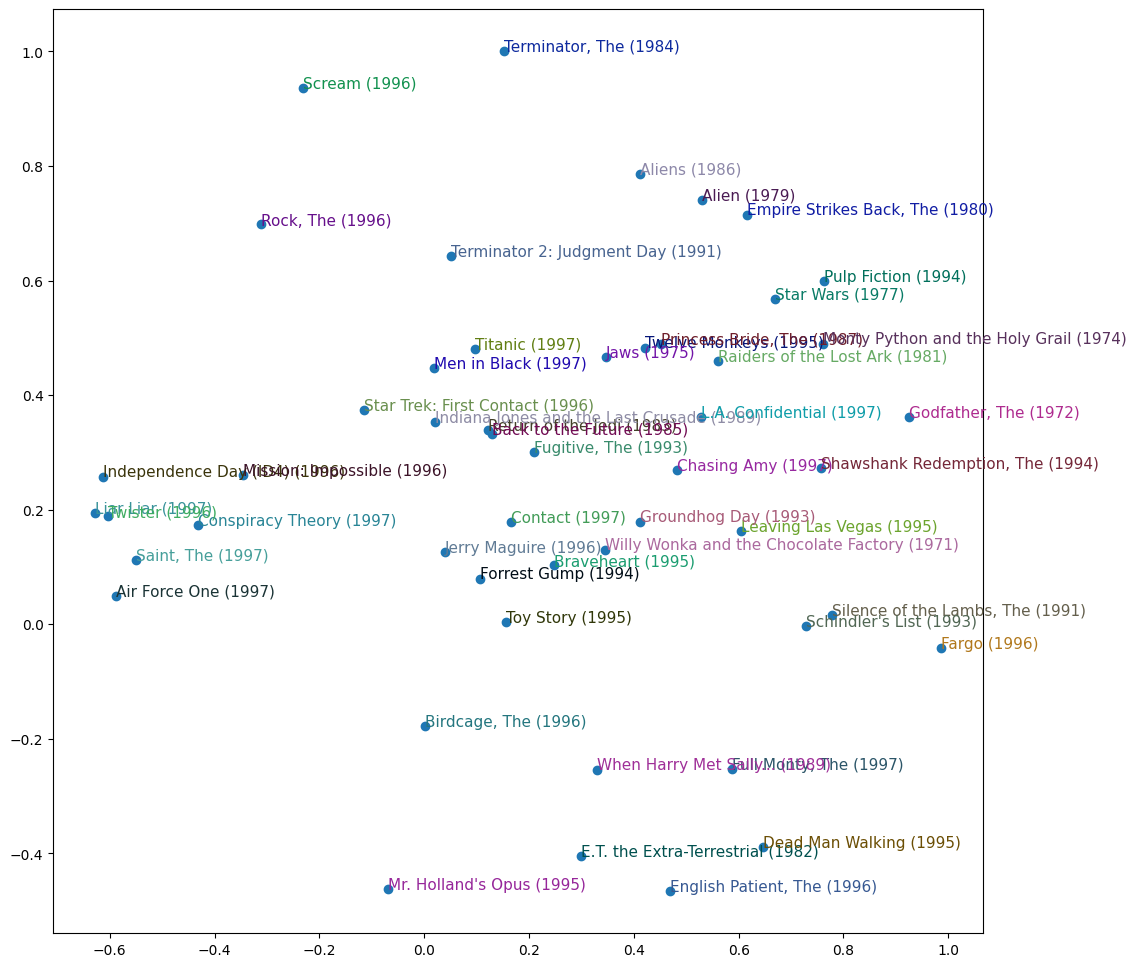

In [65]:
g = mrg_ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

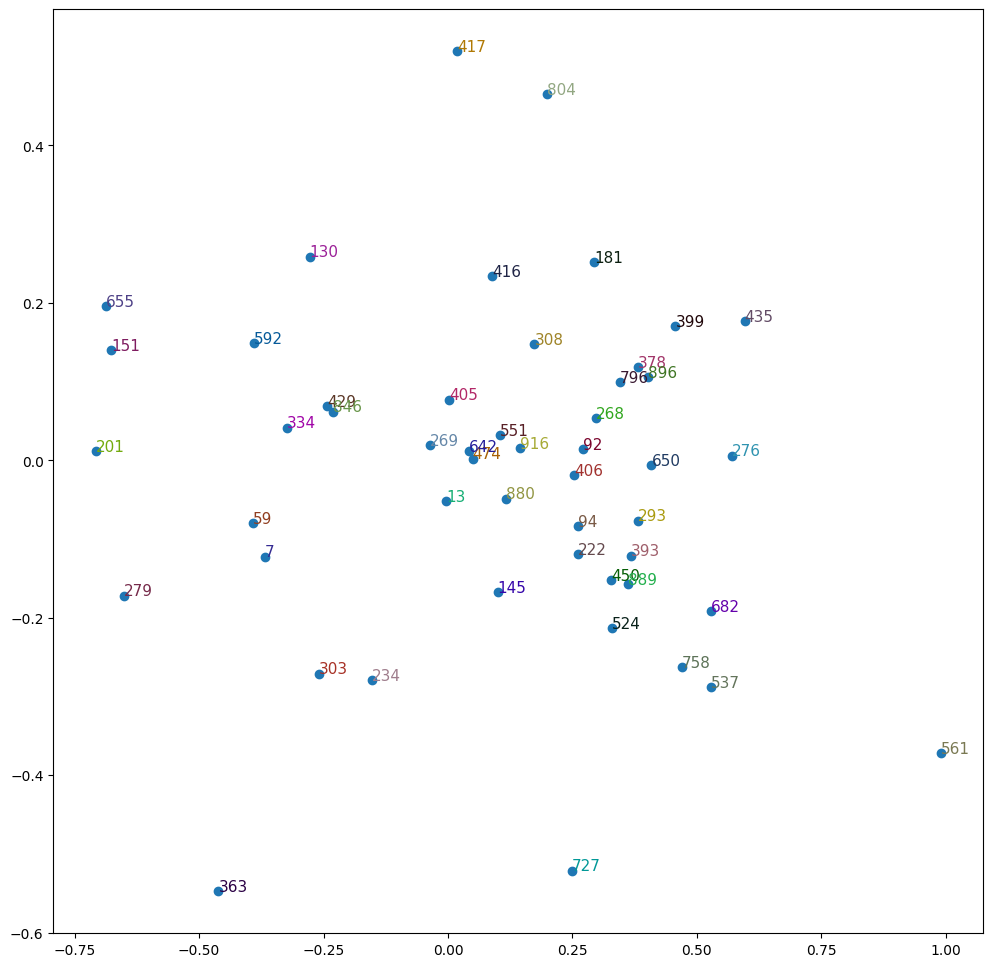

In [66]:
g = mrg_ratings.groupby('userId')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['userId'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

# Using FastAI

In [76]:
learn = collab_learner(dls, n_factors=50, y_range=(0,5.5))
learn.fit_one_cycle(5,wd=0.1)

epoch,train_loss,valid_loss,time
0,1.319977,1.295404,00:05
1,0.866718,0.944296,00:05
2,0.837544,0.904694,00:05
3,0.790671,0.888586,00:05
4,0.804611,0.885268,00:05


In [77]:
print(learn.model)

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)


In [78]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'Star Wars (1977)',
 'Shawshank Redemption, The (1994)',
 'Good Will Hunting (1997)',
 'L.A. Confidential (1997)']

In [79]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Quiet Man, The (1952)'

https://www.kaggle.com/code/jhoward/collaborative-filtering-deep-dive?scriptVersionId=99475018&cellId=113